In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
from PIL import Image

In [11]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline
img = Image.open("../data/Dataset_img/test/normal/49 (4).jpg")

Image fprmat:JPEG; shape: (650, 650); color scheme: L


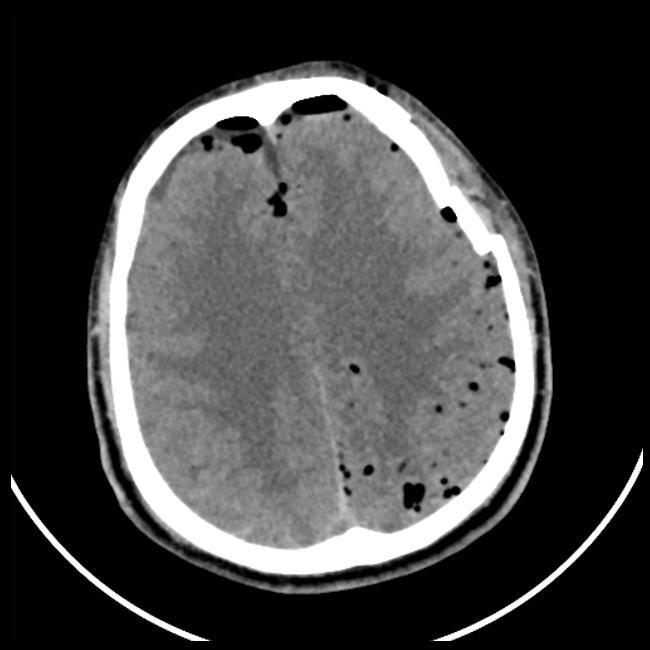

In [13]:
print(f"Image fprmat:{img.format}; shape: {img.size}; color scheme: {img.mode}")
img

L означает, что изображение в оттенках серого (grayscale).

📋 Подробнее:
Обозначение	         Что значит	    Каналов	  Диапазон значений
L	               Grayscale (8-бит)	1	    0–255
RGB	             Цветное изображение	3	    0–255 per channel
RGBA	           Цвет + альфа канал	4	    0–255

Image array shape: (650, 650)


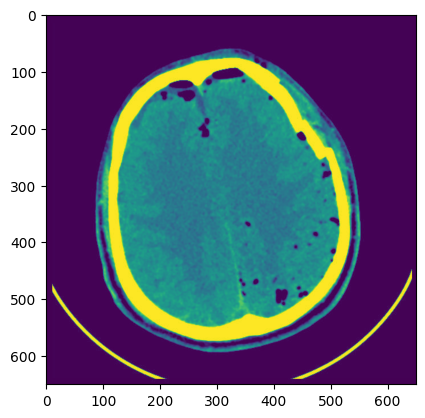

In [15]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.show()


In [19]:
img_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(650, 650), dtype=uint8)

In [21]:

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # [0,1] → [-1,1]
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [22]:
# Загрузка данных с помощью ImageFolder
train_dataset = datasets.ImageFolder(
    root='../data/Dataset_img/train',
    transform=train_transforms
)

test_dataset = datasets.ImageFolder(
    root='../data/Dataset_img/test',
    transform=test_transforms
)

# Создание загрузчиков данных
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# Проверка загрузки данных
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")
print(f"Классы: {train_dataset.classes}")

Размер тренировочного набора: 1483
Размер тестового набора: 636
Классы: ['normal', 'stroke']


🧩 Что такое DataLoader?
DataLoader — это обёртка над датасетом, которая:

Разбивает данные на батчи (mini-batches)

Перемешивает (shuffle) данные (при необходимости)

Загружает данные в фоновом режиме (асинхронно) с помощью num_workers

Позволяет удобно итерироваться по данным в цикле for

📦 Пример: без DataLoader
Если бы ты не использовал DataLoader, то пришлось бы вручную:

Доставать по 32 изображения

Делать батчи

Следить за порядком, перемешиванием и т.д.

❓ После нормализации в DataLoader попадают тензоры или картинки?
Ответ: → тензоры.

Почему:
В трансформациях у тебя есть transforms.ToTensor(), которая:

Преобразует картинку (PIL.Image) → в torch.Tensor

Меняет диапазон значений: [0, 255] → [0.0, 1.0]

Потом идёт Normalize(...), и уже над тензором применяется нормализация.

👉 Поэтому в DataLoader попадают уже готовые тензоры с размером [batch_size, C, H, W], где:

batch_size = 32 (например)

C = 1 (если grayscale) или 3 (если RGB)

H, W = 128 (размер, который ты задал в Resize)

📦 Почему batch_size=32?
Это — размер мини-батча, то есть сколько изображений обрабатывается за один шаг обучения.

Как выбрать размер батча:
32 — это типичное значение по умолчанию. Оно даёт баланс между:

производительностью (можно обрабатывать много данных за раз),

и стабильностью обучения (батчи с более чем 1 примером улучшают сглаженность градиентов),

памятью (не слишком большой, чтобы не вылететь из видеопамяти на GPU).

Можешь выбрать другое значение:
8, 16, 32, 64 — популярные варианты

Главное — чтобы влезало в память GPU или RAM

🧵 Почему num_workers=4?
num_workers — это количество параллельных потоков, которые читают и обрабатывают изображения из диска.

Зачем:
Когда ты загружаешь изображения (особенно с аугментациями), это может быть медленно. PyTorch позволяет использовать несколько процессов, чтобы:

параллельно загружать и преобразовывать изображения,

ускорить подачу данных на обучение.

Как выбрать:
num_workers=0 — всё грузится в основном потоке (медленно, но безопасно)

num_workers=2–4 — обычный выбор для CPU

num_workers > 4 — можно на мощных многопоточных системах

⚠️ В Windows бывает нужно ставить num_workers=0, чтобы избежать проблем с multiprocessing.


🧠 Почему это важно?
Нейросеть в PyTorch ожидает на вход батч тензоров, а не одиночные картинки.

✅ Значит:
Да, train_loader — это итеруемый объект, возвращающий пары (images, labels) в виде тензоров

Он полностью совместим с model(...) — ты можешь подавать images прямо в модель